## Dependencies Setup

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

## Hyperparameter Configuration

In [43]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 64
EPOCHS = 15
LR = 0.001

Using device: cuda


## Define Transform for the Data

In [44]:
transform = transforms.Compose([
	transforms.Grayscale(),
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,))
])

## Dataset Setup

In [45]:
dataset = datasets.ImageFolder("../data", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

## Model Definition

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
	def __init__(self, num_classes=10):
		super().__init__()
		self.conv1 = nn.Conv2d(1, 32, 3)
		self.pool = nn.MaxPool2d(2)
		self.conv2 = nn.Conv2d(32, 64, 3)
		self.fc1 = nn.Linear(64 * 5 * 5, 128)
		self.fc2 = nn.Linear(128, num_classes)
		
	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = x.view(-1, 64 * 5 * 5)
		x = F.relu(self.fc1(x))
		return self.fc2(x)

## Training

In [47]:
model = SimpleCNN(num_classes=10).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Starting training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss:.4f} | Acc: {acc:.2f}%")
print("Training complete.")


Starting training...
Epoch 1/15 | Loss: 113.1810 | Acc: 71.29%
Epoch 2/15 | Loss: 56.3390 | Acc: 86.21%
Epoch 3/15 | Loss: 45.6405 | Acc: 88.74%
Epoch 4/15 | Loss: 38.7656 | Acc: 90.46%
Epoch 5/15 | Loss: 32.6254 | Acc: 91.83%
Epoch 6/15 | Loss: 26.2337 | Acc: 93.40%
Epoch 7/15 | Loss: 22.1547 | Acc: 94.41%
Epoch 8/15 | Loss: 17.0017 | Acc: 95.76%
Epoch 9/15 | Loss: 13.1624 | Acc: 96.46%
Epoch 10/15 | Loss: 8.8582 | Acc: 97.80%
Epoch 11/15 | Loss: 6.0069 | Acc: 98.71%
Epoch 12/15 | Loss: 4.4489 | Acc: 99.21%
Epoch 13/15 | Loss: 2.5814 | Acc: 99.50%
Epoch 14/15 | Loss: 1.2179 | Acc: 99.86%
Epoch 15/15 | Loss: 0.9884 | Acc: 99.90%
Training complete.


## Validation

Validation Accuracy: 90.00%


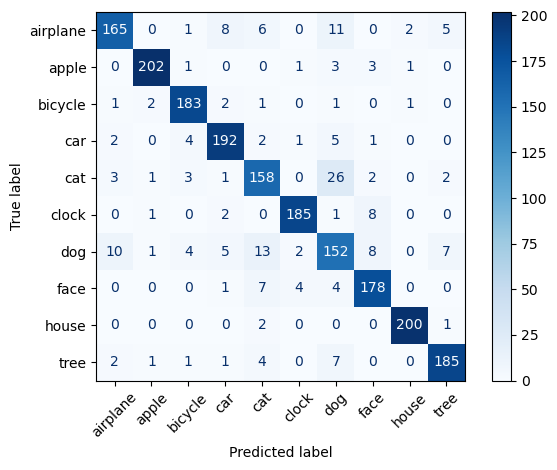

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

CLASSES = dataset.classes

model.eval()

total = 0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.tight_layout()
plt.show()